# Random walk forecast

This notebook contains a small toy example, where TACTiS is used to forecast the distribution of the future values of a random walk process.

In [1]:
import os
import sys
import torch
from torch import nn
import numpy as np
from pathlib import Path
from torch.nn import functional as F
from einops import rearrange

PATH = Path(os.path.abspath(os.curdir)).parent
import sys
sys.path.append(str(PATH))

from pactis.core.adapter import InputAdapter
from pactis.core.config import LatentQueryConfig, CrossAttentionLayerConfig, SelfAttentionBlockConfig, PerceiverEncoderConfig, PerceiverDecoderConfig
from pactis.core.encoder import PerceiverIO, PerceiverEncoder, PerceiverDecoder
from pactis.core.decoder import AttentionalCopula, CopulaDecoder
from pactis.core.pactis import PACTiS

PATH = PATH.parent
sys.path.append(str(PATH))
from tactis.tactis.model.decoder import CopulaDecoder as CD

/home/junix/PyProject/.base3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda")

In [3]:
import wandb as wb
%env "WANDB_NOTEBOOK_NAME" "random-walk"
run = wb.init(project="pactis",
              notes="tracked random walk run",
              tags=["random-walk", "debug"])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


env: "WANDB_NOTEBOOK_NAME"="random-walk"


wandb: Currently logged in as: jr-lin. Use `wandb login --relogin` to force relogin


## Dataset definition

In [4]:
def generate_random_data():
    # Make a simple dataset just to test
    np.random.seed(12345)
    
    n = 100000
    p = 10

    X = np.cumsum(np.random.randn(p, n), axis=1)

    X_train = X[:, : n//2]
    X_test = X[:, n//2 :]
    
    return X_train, X_test

## Model definition

In [5]:
# [batch, series, time_steps]
# [256, 10, 20]
EncoderConfig = PerceiverEncoderConfig.create_from_config(InputAdapter(48),
                                                          LatentQueryConfig(num_latents=50,
                                                                            num_latent_dim=16),
                                                          CrossAttentionLayerConfig(num_heads=3,
                                                                                    num_q_input_dim=16,
                                                                                    num_kv_input_dim=48,
                                                                                    num_qk_dim=48),
                                                                                    # num_v_dim=64),
                                                          SelfAttentionBlockConfig(num_layers=2,
                                                                                   num_heads=3,
                                                                                   num_dim=16,
                                                                                   num_qk_dim=48),
                                                        num_cross_attn_layers=1,
                                                        num_self_attn_blocks=2,
                                                        )
DecoderConfig = PerceiverDecoderConfig.create_from_config(LatentQueryConfig(num_latents=200,
                                                                            num_latent_dim=48), 
                                                          CrossAttentionLayerConfig(num_heads=3,
                                                                                  num_q_input_dim=48, 
                                                                                  num_kv_input_dim=16,
                                                                                  num_qk_dim=48))

copula = {"attn_heads":3, "attn_dim": 16, "attn_layers": 3, "mlp_dim": 16, "mlp_layers": 3, "resolution": 50, "dropout":0}
cd = {"attention_heads":3, "attention_dim": 16, "attention_layers": 3, "mlp_dim": 16, "mlp_layers": 3, "resolution": 50, "dropout":0}

dsf = {"mlp_layers": 2, "mlp_dim": 8, "flow_layers": 2, "flow_hid_dim": 8}

In [6]:
Encoder = PerceiverIO.from_config(EncoderConfig, DecoderConfig).to("cuda")
Decoder = CopulaDecoder(input_dim = 48, 
                        attentional_copula = copula, 
                        dsf_marginal = dsf).to("cuda")
Decoder2 = CD(input_dim = 48, 
              attentional_copula = cd, 
              dsf_marginal = dsf).to("cuda")
net = PACTiS(num_series = 10,
             series_embedding_dim = 5, 
             num_embedding_layers = 3,
             decoder = Decoder2,
             encoder = Encoder,
             positional_encoding={"dropout":0}).to("cuda")

In [13]:
Deocder = AttentionalCopula(48, **copula).to("cuda")

In [14]:
%%timeit -n 100
Decoder.loss(torch.randn((3, 10, 20, 48), device=device), 
            mask=mask,
            true_value=torch.randn((3, 10, 20), device=device))

15.8 ms ± 205 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
from tqdm import tqdm
device = "cuda"
# mask = torch.Tensor([0]+[1]*8+[0]+[1]*9+[0]).bool().to(device)
# mask = [0]+[1]*8+[0]+[1]*9+[0]
mask = [1]*10+[0]*10
for _ in tqdm(range(1000)):
    Decoder.loss(torch.randn((3, 10, 20, 48), device=device), 
                mask=mask,
                true_value=torch.randn((3, 10, 20), device=device))

100%|██████████| 1000/1000 [00:16<00:00, 61.91it/s]


In [12]:
from tqdm import tqdm
from time import time
device = "cuda"
# mask = torch.Tensor([0]+[1]*8+[0]+[1]*9+[0]).bool().to(device)
# mask = [0]+[1]*8+[0]+[1]*9+[0]
mask = [1]*10+[0]*10
for _ in tqdm(range(1000)):
    Decoder.loss(torch.randn((3, 10, 20, 48), device=device), 
                mask=mask,
                true_value=torch.randn((3, 10, 20), device=device))

100%|██████████| 1000/1000 [00:15<00:00, 66.05it/s]


In [7]:
import numpy as np
from pactis.core.utils import TimeSeriesOM
mask = [1]*10+[0]*10


In [49]:
A = {i:i for i in range(1000)}
B = torch.randn(3, 10, 20, 48).cuda()

In [55]:
%%timeit -n 10000
B[:,:,:,[1,2,3,4,5,6]]

65.5 µs ± 550 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [5]:
%%timeit -n 100
time_horizon = TimeSeriesOM(3, mask)
mid_points_map = {}
index_mask = {}
while time_horizon.has_missing_points():
    current_mid_points_map, current_index_mask = time_horizon.next_to_fill()
    mid_points_map, index_mask= {**mid_points_map, **current_mid_points_map}, {**index_mask, **current_index_mask}

338 µs ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
mask = torch.Tensor([0]+[1]*8+[0]+[1]*9+[0]).bool().to(device)
Decoder.loss(torch.randn((3, 10, 20, 48), device=device), 
             mask=mask,
             true_value=torch.randn((3, 10, 20), device=device))

In [14]:
mask = torch.Tensor([0]+[1]*8+[0]+[1]*9+[0]).bool().to(device)
net.loss(torch.randn((1, 10, 20), device = device), mask)

tensor([69.6254], device='cuda:0', grad_fn=<SubBackward0>)

In [5]:
def create_net():
    net = TACTiS(
        num_series=10,
        series_embedding_dim=5,
        input_encoder_layers=3,
        input_encoding_normalization=True,
        data_normalization="standardization",
        loss_normalization="series",
        positional_encoding={
            "dropout": 0.0,},
        temporal_encoder={
            "attention_layers": 3,
            "attention_heads": 3,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.0},
        copula_decoder={
            "min_u": 0.01,
            "max_u": 0.99,
            "attentional_copula": {
                "attention_heads": 3,
                "attention_layers": 3,
                "attention_dim": 16,
                "mlp_layers": 3,
                "mlp_dim": 16,
                "resolution": 50,},
            "dsf_marginal": {
                "mlp_layers": 2,
                "mlp_dim": 8,
                "flow_layers": 2,
                "flow_hid_dim": 8,}},)
    return net.to(device)

## Model training

In [6]:
def step(net, optimizer, batch_size, data, num_time_steps, missing_points):
    device = "cuda"
    max_idx = data.shape[1] - num_time_steps
    value = []
    mask = torch.ones(num_time_steps, device=device).bool()
    missing_index = np.random.choice(range(num_time_steps), size=missing_points, replace=False)
    mask[missing_index] = False
    for _ in range(batch_size):
        idx = np.random.randint(0, max_idx)
        value.append(data[:, idx:idx+num_time_steps])

    value = torch.Tensor(value).to(device)
    optimizer.zero_grad()
    loss = net.loss(value, mask)
    loss.backward()
    optimizer.step()
    
    return loss.item()

def step2(net, optimizer, batch_size, data, hist_length, pred_length):
    max_idx = data.shape[1] - (hist_length + pred_length)
    
    hist_values = []
    pred_values = []
    for _ in range(batch_size):
        idx = np.random.randint(0, max_idx)
        hist_values.append(data[:, idx:idx+hist_length])
        pred_values.append(data[:, idx+hist_length:idx+hist_length+pred_length])
    
    # [batch, series, time steps]
    hist_value = torch.Tensor(hist_values).to(device)
    pred_value = torch.Tensor(pred_values).to(device)
    hist_time = torch.arange(0, hist_length, device=device)[None, :].expand(batch_size, -1)
    pred_time = torch.arange(hist_length, hist_length + pred_length, device=device)[None, :].expand(batch_size, -1)
    
    optimizer.zero_grad()
    loss = net.loss(hist_time, hist_value, pred_time, pred_value)
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [10]:
net = PACTiS(num_series = 10,
             series_embedding_dim = 5, 
             num_embedding_layers = 3,
             encoder = Encoder,
             decoder = Decoder,
             positional_encoding={"dropout":0}).to("cuda")
data_train, data_test = generate_random_data()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0)

In [11]:
from tqdm import tqdm
avg_loss = []

NUM_EPOCHS = 500  # The model is very slow to train
NUM_BATCHES = 100

for epoch in tqdm(range(NUM_EPOCHS)):
    running_sum = 0
    for batch in range(NUM_BATCHES):
        loss = step(net, optimizer, 256, data_train, 20, 10)
        running_sum += loss
        print(f"Epoch {epoch} Batch {batch} Loss {loss}")
    avg_loss.append(running_sum / NUM_BATCHES)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 Batch 0 Loss 21.9051456451416
Epoch 0 Batch 1 Loss 21.587162017822266
Epoch 0 Batch 2 Loss 21.525638580322266
Epoch 0 Batch 3 Loss 21.0835018157959
Epoch 0 Batch 4 Loss 21.02060890197754
Epoch 0 Batch 5 Loss 20.696456909179688
Epoch 0 Batch 6 Loss 20.006120681762695
Epoch 0 Batch 7 Loss 20.086286544799805
Epoch 0 Batch 8 Loss 19.49051856994629
Epoch 0 Batch 9 Loss 19.162784576416016
Epoch 0 Batch 10 Loss 19.78717041015625
Epoch 0 Batch 11 Loss 18.87733268737793
Epoch 0 Batch 12 Loss 19.595754623413086
Epoch 0 Batch 13 Loss 18.181581497192383
Epoch 0 Batch 14 Loss 18.440418243408203
Epoch 0 Batch 15 Loss 17.17255210876465
Epoch 0 Batch 16 Loss 16.993406295776367
Epoch 0 Batch 17 Loss 16.888879776000977
Epoch 0 Batch 18 Loss 16.729862213134766
Epoch 0 Batch 19 Loss 16.927021026611328
Epoch 0 Batch 20 Loss 18.82392692565918
Epoch 0 Batch 21 Loss 16.23856544494629
Epoch 0 Batch 22 Loss 17.159719467163086
Epoch 0 Batch 23 Loss 17.80675506591797
Epoch 0 Batch 24 Loss 16.4624881744384

  0%|          | 1/500 [00:36<5:03:09, 36.45s/it]

Epoch 0 Batch 99 Loss 14.467707633972168
Epoch 1 Batch 0 Loss 14.579150199890137
Epoch 1 Batch 1 Loss 17.863805770874023
Epoch 1 Batch 2 Loss 14.861178398132324
Epoch 1 Batch 3 Loss 18.019269943237305
Epoch 1 Batch 4 Loss 15.154675483703613
Epoch 1 Batch 5 Loss 15.0510835647583
Epoch 1 Batch 6 Loss 17.155094146728516
Epoch 1 Batch 7 Loss 16.86414909362793
Epoch 1 Batch 8 Loss 14.914506912231445
Epoch 1 Batch 9 Loss 15.2517671585083
Epoch 1 Batch 10 Loss 14.58611011505127
Epoch 1 Batch 11 Loss 16.614704132080078
Epoch 1 Batch 12 Loss 14.869348526000977
Epoch 1 Batch 13 Loss 14.50192928314209
Epoch 1 Batch 14 Loss 15.746604919433594
Epoch 1 Batch 15 Loss 15.373408317565918
Epoch 1 Batch 16 Loss 15.008008003234863
Epoch 1 Batch 17 Loss 17.254913330078125
Epoch 1 Batch 18 Loss 14.449029922485352
Epoch 1 Batch 19 Loss 15.92492961883545
Epoch 1 Batch 20 Loss 16.444543838500977
Epoch 1 Batch 21 Loss 14.403042793273926
Epoch 1 Batch 22 Loss 14.929984092712402
Epoch 1 Batch 23 Loss 18.018753051

  0%|          | 2/500 [01:12<4:58:39, 35.98s/it]

Epoch 1 Batch 99 Loss 13.963958740234375
Epoch 2 Batch 0 Loss 15.024307250976562
Epoch 2 Batch 1 Loss 15.091292381286621
Epoch 2 Batch 2 Loss 16.80003547668457
Epoch 2 Batch 3 Loss 14.968167304992676
Epoch 2 Batch 4 Loss 14.236930847167969
Epoch 2 Batch 5 Loss 16.51009178161621
Epoch 2 Batch 6 Loss 14.689435005187988
Epoch 2 Batch 7 Loss 14.818466186523438
Epoch 2 Batch 8 Loss 15.124140739440918
Epoch 2 Batch 9 Loss 15.648508071899414
Epoch 2 Batch 10 Loss 18.492813110351562
Epoch 2 Batch 11 Loss 15.44859504699707
Epoch 2 Batch 12 Loss 22.5250301361084
Epoch 2 Batch 13 Loss 14.716758728027344
Epoch 2 Batch 14 Loss 14.854763984680176
Epoch 2 Batch 15 Loss 14.248069763183594
Epoch 2 Batch 16 Loss 14.664850234985352
Epoch 2 Batch 17 Loss 14.63098430633545
Epoch 2 Batch 18 Loss 15.116128921508789
Epoch 2 Batch 19 Loss 15.90422534942627
Epoch 2 Batch 20 Loss 16.24013328552246
Epoch 2 Batch 21 Loss 18.06575584411621
Epoch 2 Batch 22 Loss 14.722848892211914
Epoch 2 Batch 23 Loss 13.9959659576

  1%|          | 3/500 [01:47<4:55:37, 35.69s/it]

Epoch 2 Batch 99 Loss 15.772723197937012
Epoch 3 Batch 0 Loss 15.259735107421875
Epoch 3 Batch 1 Loss 14.343945503234863
Epoch 3 Batch 2 Loss 14.761609077453613
Epoch 3 Batch 3 Loss 14.269238471984863
Epoch 3 Batch 4 Loss 14.534329414367676
Epoch 3 Batch 5 Loss 15.269267082214355
Epoch 3 Batch 6 Loss 16.482370376586914
Epoch 3 Batch 7 Loss 16.249494552612305
Epoch 3 Batch 8 Loss 15.658652305603027
Epoch 3 Batch 9 Loss 14.400530815124512
Epoch 3 Batch 10 Loss 14.487278938293457
Epoch 3 Batch 11 Loss 14.762850761413574
Epoch 3 Batch 12 Loss 14.33403205871582
Epoch 3 Batch 13 Loss 14.949790000915527
Epoch 3 Batch 14 Loss 15.298059463500977
Epoch 3 Batch 15 Loss 13.649785041809082
Epoch 3 Batch 16 Loss 13.878756523132324
Epoch 3 Batch 17 Loss 15.271890640258789
Epoch 3 Batch 18 Loss 15.775181770324707
Epoch 3 Batch 19 Loss 13.921592712402344
Epoch 3 Batch 20 Loss 14.350130081176758
Epoch 3 Batch 21 Loss 14.788698196411133
Epoch 3 Batch 22 Loss 17.060794830322266
Epoch 3 Batch 23 Loss 14.95

  1%|          | 4/500 [02:22<4:54:10, 35.59s/it]

Epoch 3 Batch 99 Loss 17.482324600219727
Epoch 4 Batch 0 Loss 18.108640670776367
Epoch 4 Batch 1 Loss 14.06824779510498
Epoch 4 Batch 2 Loss 14.220019340515137
Epoch 4 Batch 3 Loss 16.743314743041992
Epoch 4 Batch 4 Loss 14.225967407226562
Epoch 4 Batch 5 Loss 19.69759178161621
Epoch 4 Batch 6 Loss 15.687255859375
Epoch 4 Batch 7 Loss 15.397130012512207
Epoch 4 Batch 8 Loss 15.034357070922852
Epoch 4 Batch 9 Loss 14.417068481445312
Epoch 4 Batch 10 Loss 14.942733764648438
Epoch 4 Batch 11 Loss 15.867441177368164
Epoch 4 Batch 12 Loss 14.524438858032227
Epoch 4 Batch 13 Loss 15.441756248474121
Epoch 4 Batch 14 Loss 14.105298042297363
Epoch 4 Batch 15 Loss 15.871910095214844
Epoch 4 Batch 16 Loss 15.468719482421875
Epoch 4 Batch 17 Loss 14.451349258422852
Epoch 4 Batch 18 Loss 14.044957160949707
Epoch 4 Batch 19 Loss 14.801581382751465
Epoch 4 Batch 20 Loss 16.395713806152344
Epoch 4 Batch 21 Loss 13.985552787780762
Epoch 4 Batch 22 Loss 14.2420072555542
Epoch 4 Batch 23 Loss 19.11407089

  1%|          | 5/500 [03:09<5:27:42, 39.72s/it]

Epoch 4 Batch 99 Loss 17.48259162902832
Epoch 5 Batch 0 Loss 14.06823444366455
Epoch 5 Batch 1 Loss 16.50644302368164
Epoch 5 Batch 2 Loss 16.330646514892578
Epoch 5 Batch 3 Loss 14.229182243347168
Epoch 5 Batch 4 Loss 16.075151443481445
Epoch 5 Batch 5 Loss 15.483797073364258
Epoch 5 Batch 6 Loss 14.828981399536133
Epoch 5 Batch 7 Loss 14.99487018585205
Epoch 5 Batch 8 Loss 15.792016983032227
Epoch 5 Batch 9 Loss 15.30899715423584
Epoch 5 Batch 10 Loss 14.506207466125488
Epoch 5 Batch 11 Loss 15.429590225219727
Epoch 5 Batch 12 Loss 14.974902153015137
Epoch 5 Batch 13 Loss 15.030508995056152
Epoch 5 Batch 14 Loss 16.927438735961914
Epoch 5 Batch 15 Loss 16.509716033935547
Epoch 5 Batch 16 Loss 15.784347534179688
Epoch 5 Batch 17 Loss 14.842440605163574
Epoch 5 Batch 18 Loss 14.86413288116455
Epoch 5 Batch 19 Loss 14.390283584594727
Epoch 5 Batch 20 Loss 16.467798233032227
Epoch 5 Batch 21 Loss 13.924368858337402
Epoch 5 Batch 22 Loss 15.713485717773438
Epoch 5 Batch 23 Loss 15.8127927

  1%|          | 6/500 [03:45<5:14:42, 38.22s/it]

Epoch 5 Batch 99 Loss 16.76507568359375
Epoch 6 Batch 0 Loss 18.64468002319336
Epoch 6 Batch 1 Loss 15.843871116638184
Epoch 6 Batch 2 Loss 13.836700439453125
Epoch 6 Batch 3 Loss 14.688653945922852
Epoch 6 Batch 4 Loss 14.353619575500488
Epoch 6 Batch 5 Loss 14.925500869750977
Epoch 6 Batch 6 Loss 16.992116928100586
Epoch 6 Batch 7 Loss 16.79218101501465
Epoch 6 Batch 8 Loss 14.196533203125
Epoch 6 Batch 9 Loss 15.169180870056152
Epoch 6 Batch 10 Loss 14.054980278015137
Epoch 6 Batch 11 Loss 14.776123046875
Epoch 6 Batch 12 Loss 14.775153160095215
Epoch 6 Batch 13 Loss 15.665349006652832
Epoch 6 Batch 14 Loss 16.713491439819336
Epoch 6 Batch 15 Loss 15.252287864685059
Epoch 6 Batch 16 Loss 15.642045974731445
Epoch 6 Batch 17 Loss 15.375460624694824
Epoch 6 Batch 18 Loss 13.746258735656738
Epoch 6 Batch 19 Loss 16.251493453979492
Epoch 6 Batch 20 Loss 14.90557861328125
Epoch 6 Batch 21 Loss 14.741602897644043
Epoch 6 Batch 22 Loss 15.64214038848877
Epoch 6 Batch 23 Loss 14.347796440124

  1%|          | 6/500 [04:02<5:32:50, 40.43s/it]


KeyboardInterrupt: 

The loss function of TACTiS often contains multiple plateaus.
For example, the first plateau can be the model correctly learning the global distribution, before learning the distribution conditioned on the history, and then learning the correlations between time steps.

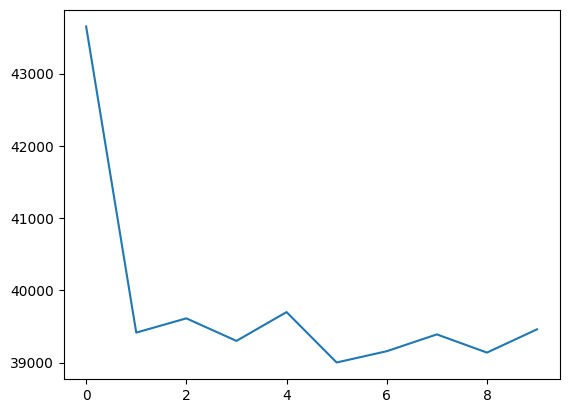

In [12]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(avg_loss)

## Sampling from the model

In [ ]:
def sample(net, num_samples, data, hist_length, pred_length):
    max_idx = data.shape[1] - (hist_length + pred_length)
    
    idx = np.random.randint(0, max_idx)
    hist_value = torch.Tensor(data[:, idx:idx+hist_length]).to(device)
    pred_value = torch.Tensor(data[:, idx+hist_length:idx+hist_length+pred_length]).to(device)
    
    # [batch, series, time steps]
    hist_value = hist_value[None, :, :]
    pred_value = pred_value[None, :, :]
    hist_time = torch.arange(0, hist_length, device=device)[None, :]
    pred_time = torch.arange(hist_length, hist_length + pred_length, device=device)[None, :]

    samples = net.sample(num_samples, hist_time, hist_value, pred_time)
    
    return samples, torch.cat([hist_value, pred_value], axis=2), torch.cat([hist_time, pred_time], axis=1)

In [ ]:
samples, pred_value, timesteps = sample(net, 1000, data_test, 10, 10)

In [ ]:
def plot_single_series(samples, target, timesteps, index):
    s_samples = samples[0, index, :, :].cpu().numpy()
    s_timesteps = timesteps[0, :].cpu().numpy()
    s_target = target[0, index, :].cpu().numpy()
    
    plt.figure()
    
    for zorder, quant, color, label in [
        [1, 0.05, (0.75,0.75,1), "5%-95%"],
        [2, 0.10, (0.25,0.25,1), "10%-90%"],
        [3, 0.25, (0,0,0.75), "25%-75%"],
    ]:
        plt.fill_between(
            s_timesteps,
            np.quantile(s_samples, quant, axis=1),
            np.quantile(s_samples, 1 - quant, axis=1),
            facecolor=color,
            interpolate=True,
            label=label,
            zorder=zorder,
        )
    
    plt.plot(
        s_timesteps,
        np.quantile(s_samples, 0.5, axis=1),
        color=(0.5,0.5,0.5),
        linewidth=3,
        label="50%",
        zorder=4,
    )
    
    plt.plot(s_timesteps, s_target, color=(0, 0, 0), linewidth=2, zorder=5, label="ground truth")
    
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1, 2, 3, 4, 0]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    
    plt.show()

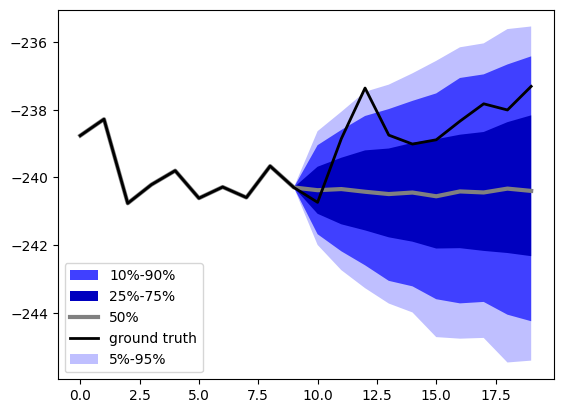

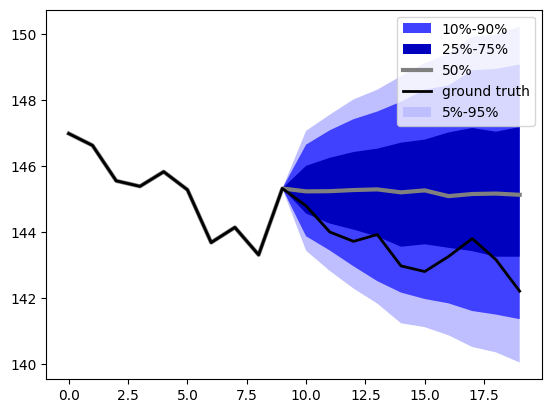

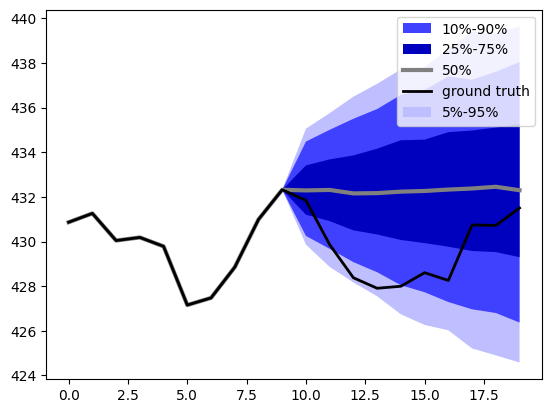

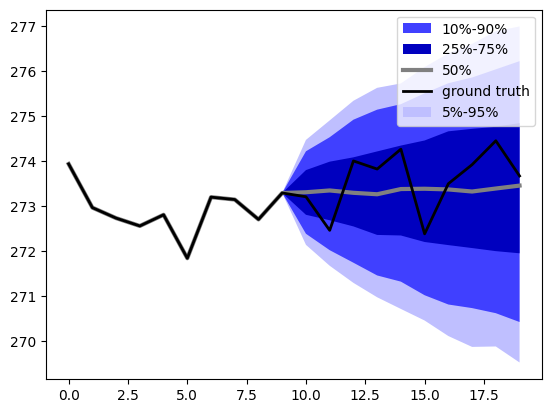

In [ ]:
for i in range(4):
    plot_single_series(samples, pred_value, timesteps, i)

The variance of the random walk process is easy to compute: since each step adds a Normal(0,1) to the previous value, then the variance of the generating process after $n$ steps is equal to $n$.

The variance in the result is the consequence of the standardization procedure, which prevents the model from learning that the variance should only depends on the step number.

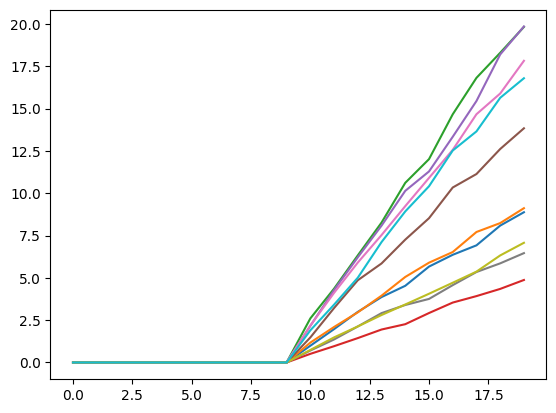

In [ ]:
plt.figure()
plt.plot(samples[0, :, :, :].var(dim=2).cpu().transpose(0,1))
plt.show()

The correlations should increase as we go to later time steps, especially for close time steps.

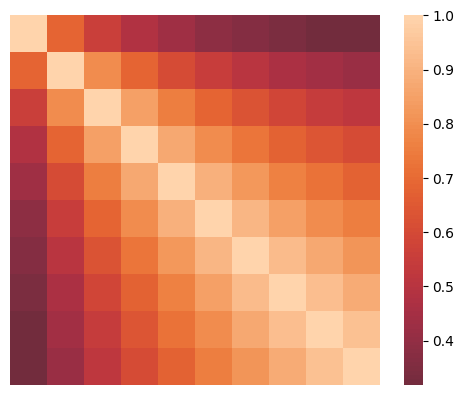

In [ ]:
corrcoef = 0
for b in range(samples.shape[0]):
    for v in range(samples.shape[1]):
        spl = samples[b,v,10:,:].cpu().numpy()
        corrcoef = corrcoef + np.corrcoef(spl)
corrcoef /= (samples.shape[0] * samples.shape[1])

plt.figure()

svm = sns.heatmap(corrcoef, robust=True, center=0, xticklabels=False, yticklabels=False)
plt.gca().set_aspect('equal', 'box')
plt.show()